In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.24MB/s]


Input shape: torch.Size([128, 1, 28, 28])
Target shape: torch.Size([128])


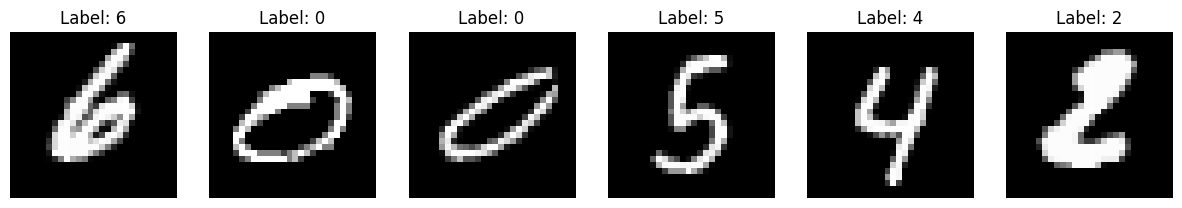

In [33]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Visualize some samples from the dataset
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print("Input shape:", example_data.shape)
print("Target shape:", example_targets.shape)
fig, ax = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    ax[i].imshow(example_data[i][0], cmap='gray')
    ax[i].set_title(f"Label: {example_targets[i].item()}")
    ax[i].axis('off')
plt.show()

# ddpm

In [3]:
device = 'cuda'

In [38]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=32):
        super(UNet, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = nn.Sequential(
            nn.Conv2d(features, features*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(features*2, features*2, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*2, features*4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(features*4, features*2, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.upconv2 = nn.ConvTranspose2d(features*2, features*2, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(features*4, features*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(features*2, features, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.upconv1 = nn.ConvTranspose2d(features, features, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(features*2, features, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(features, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, t=None):  # t is unused here, but kept for compatibility
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))

        dec2 = self.upconv2(bottleneck)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        return self.decoder1(dec1)

# --- DDPM Components ---
class DDPM:
    def __init__(self, model, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.model = model
        self.T = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)

    def encode(self, x0, t, noise=None):
        if noise is None:
            noise = torch.normal(0, 1, size=x0.shape, device=x0.device)
        a = self.alpha_hat[t].sqrt().view(-1, 1, 1, 1)
        b = (1 - self.alpha_hat[t]).sqrt().view(-1, 1, 1, 1)
        return a * x0 + b * noise

    def p_sample(self, x, t):
        model_pred = self.model(x)
        beta = self.betas[t].view(-1, 1, 1, 1)
        alpha = self.alphas[t].view(-1, 1, 1, 1)
        alpha_hat = self.alpha_hat[t].view(-1, 1, 1, 1)
        mean = (1 / alpha.sqrt()) * (x - beta / (1 - alpha_hat).sqrt() * model_pred)
        noise = torch.normal(0, 1, size=x.shape, device=x.device) if t[0] > 0 else 0
        return mean + beta.sqrt() * noise

    def decode(self, shape, steps=1000):
        x = torch.normal(0, 1, size=shape).to(device)
        for t in reversed(range(steps)):
            t_tensor = torch.full((shape[0],), t, dtype=torch.long)
            x = self.p_sample(x, t_tensor)
        return x

    def training_loss(self, x0, t):
        noise = torch.normal(0, 1, size=x0.shape, device=x0.device)
        x_t = self.encode(x0, t, noise)
        noise_pred = self.model(x_t).to(device)
        return F.mse_loss(noise_pred, noise)

    def train_ddpm(self, epochs = 15, lr = 1e-3):
        optimizer = torch.optim.Adam(self.model.parameters(), lr = lr)
        for epoch in range(epochs):
            self.model.train()
            epoch_loss = 0
            for batch in train_loader:
                x, _ = batch
                x = x.to(device)
                t = torch.randint(0, self.T, (x.size(0),), device=device).long()
                loss = self.training_loss(x, t)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}")

In [39]:
unet = UNet().to(device)
time_steps = 2000
ddpm1 = DDPM(unet,time_steps)
ddpm1.train_ddpm(epochs = 50)

Epoch 1, Loss: 0.10312651623604394
Epoch 2, Loss: 0.0418947710117488
Epoch 3, Loss: 0.03589178016508566
Epoch 4, Loss: 0.03324244483145696
Epoch 5, Loss: 0.030956837469771473
Epoch 6, Loss: 0.029729059232132777
Epoch 7, Loss: 0.028534007284528158
Epoch 8, Loss: 0.027544491628466894
Epoch 9, Loss: 0.02679414393852896
Epoch 10, Loss: 0.026213253794639096
Epoch 11, Loss: 0.02535393517583545
Epoch 12, Loss: 0.025333645725761775
Epoch 13, Loss: 0.024839985482235833
Epoch 14, Loss: 0.02422845257378654
Epoch 15, Loss: 0.023626613700742535
Epoch 16, Loss: 0.024485963535731407
Epoch 18, Loss: 0.02309705951272933
Epoch 19, Loss: 0.02295987298692277
Epoch 20, Loss: 0.022449622359643106
Epoch 21, Loss: 0.023169449796634062
Epoch 22, Loss: 0.022211875337591048
Epoch 23, Loss: 0.02230924247368884
Epoch 24, Loss: 0.02253923720237352
Epoch 25, Loss: 0.0219222686604968
Epoch 26, Loss: 0.022152446246128093
Epoch 27, Loss: 0.021456809080978318
Epoch 28, Loss: 0.021655955121540692
Epoch 29, Loss: 0.021366

In [6]:
unet.load_state_dict(torch.load('unet_m.pth'))

<All keys matched successfully>

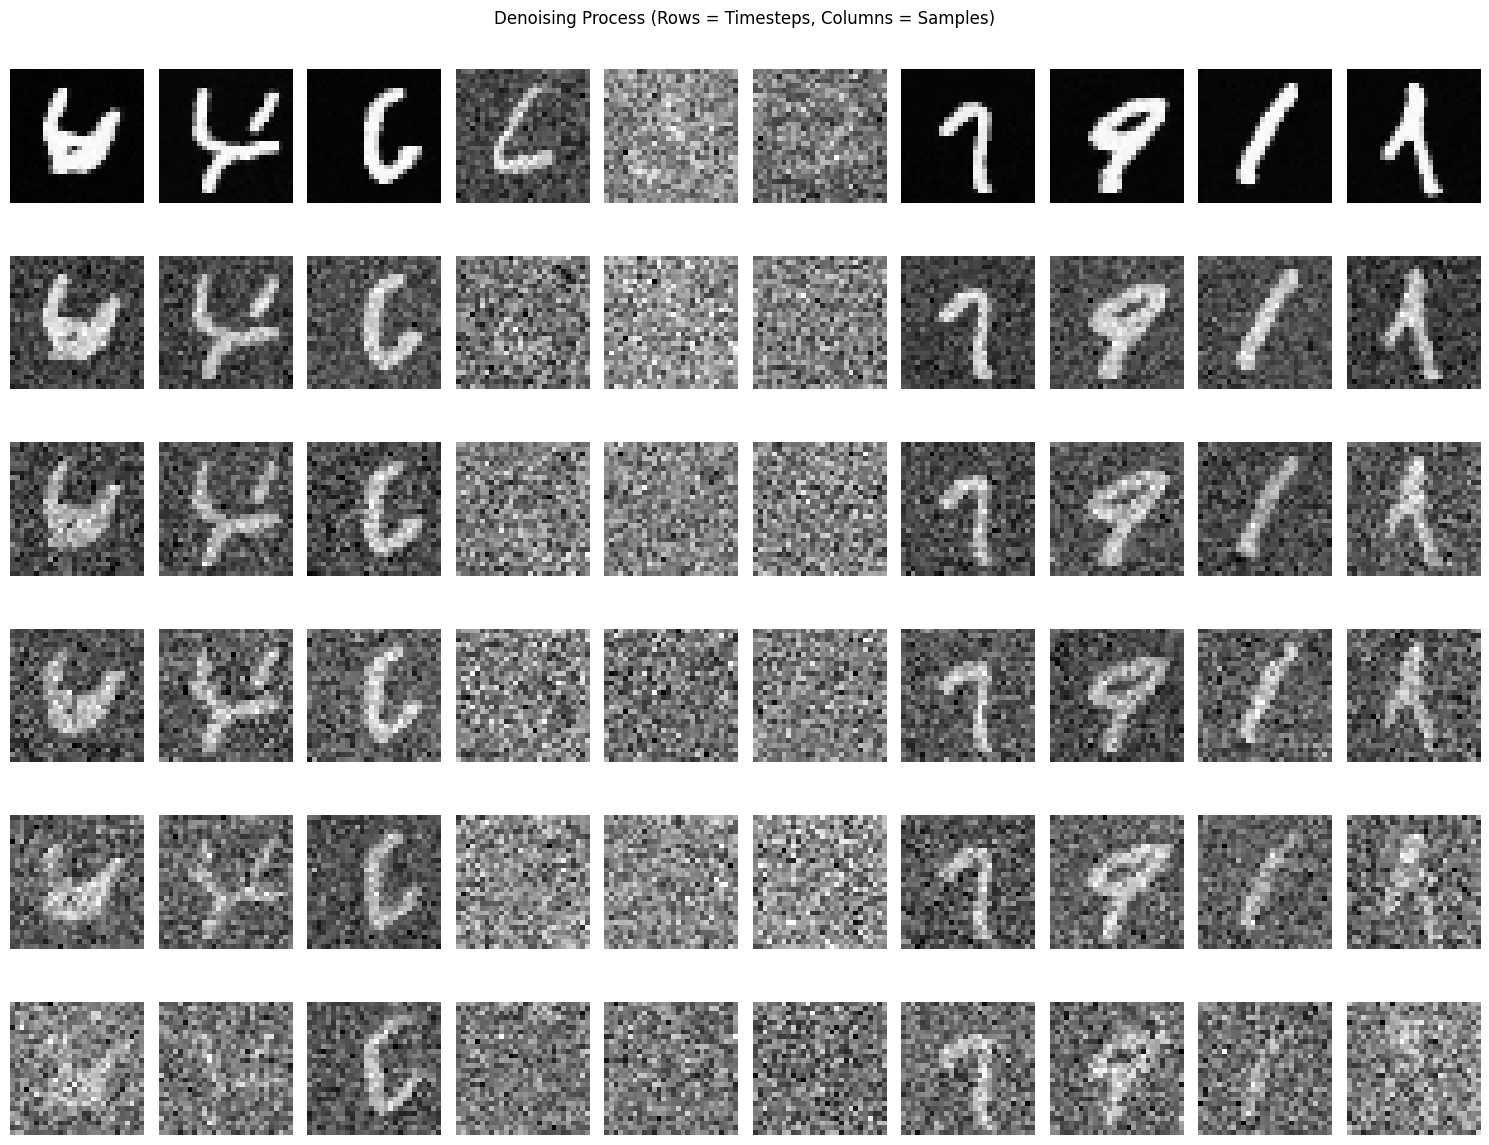

In [41]:
## (c) Visualizing the generative process of the DDPM model ####

def denoise_and_visualize(dif_model, num_samples=10, num_timesteps = 15, steps_to_show=[0, 3, 6, 9, 12, 14]):
    dif_model.model.eval()
    with torch.no_grad():
        # Generate initial noise
        x = torch.normal(0,1,(num_samples, 1,28,28)).to(device)
        fig, ax = plt.subplots(len(steps_to_show), num_samples, figsize=(15, 2 * len(steps_to_show)))

        for i, t in enumerate(reversed(range(num_timesteps))):
            t_tensor = torch.tensor([t] * num_samples).to(device)
            x = dif_model.p_sample(x, t_tensor).detach()
            if t in steps_to_show:
                for j in range(num_samples):
                    ax[steps_to_show.index(t), j].imshow(x[j][0].cpu(), cmap='gray')
                    ax[steps_to_show.index(t), j].axis('off')
                ax[steps_to_show.index(t), 0].set_ylabel(f"t={t}", fontsize=12)

        plt.suptitle("Denoising Process (Rows = Timesteps, Columns = Samples)")
        plt.tight_layout()
        plt.show()

# Visualize the denoising process
denoise_and_visualize(ddpm1, num_samples=10, num_timesteps=time_steps, steps_to_show=[0,200,400,600,800,999])

In [22]:
torch.save(unet.state_dict(), 'unet_m1.pth')

# vae

In [7]:
def inference(model1, model2, t1, t2, num_samples):
  x = torch.normal(0, 1, (num_samples, 1,28,28)).to(device)
  x, _ , _= model1(x)
  for i in range(1,t1):
    t = torch.full((num_samples,), i, dtype=torch.long)
    x = model2.encode(x,t)
  for i in range(t2, 0):
    t = torch.full((num_samples,), i, dtype=torch.long)
    x = model2.p_sample(x,t)
  return x

In [8]:
### Define the VAE model ###
## Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU()
        )
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.decoder(x)
        return x

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.normal(0,1,std.shape).to(device)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [9]:
device = 'cuda'
latent_dim = 50
input_dim = (1,28,28)
vae_model = VAE(input_dim, latent_dim).to(device)

In [10]:
vae_model.load_state_dict(torch.load('vae_model.pth'))

<All keys matched successfully>

In [10]:
### (a) Training the VAE model ###
def loss_function(x, x_recon, mu, logvar):
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
    kl_divg = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divg

optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
num_epochs = 25
for epoch in range(num_epochs):
    vae_model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = vae_model(x)
        loss = loss_function(x, x_recon, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset)}")

Epoch 1, Loss: 180.68060908203125
Epoch 2, Loss: 96.7985945719401
Epoch 3, Loss: 78.52879283040365
Epoch 4, Loss: 71.06003577473959
Epoch 5, Loss: 67.42899327799479
Epoch 6, Loss: 65.56826638183594
Epoch 7, Loss: 64.3006392171224
Epoch 8, Loss: 63.29837928059896
Epoch 9, Loss: 62.591995361328124
Epoch 10, Loss: 62.07719156087239
Epoch 11, Loss: 61.43706278483073
Epoch 12, Loss: 60.94347641601563
Epoch 13, Loss: 60.57343055013021
Epoch 14, Loss: 60.23323312988281
Epoch 15, Loss: 59.94797940266927
Epoch 16, Loss: 59.58043212076823
Epoch 17, Loss: 59.49896649576823
Epoch 18, Loss: 59.10572667643229
Epoch 19, Loss: 58.90002199707031
Epoch 20, Loss: 58.6259496500651
Epoch 21, Loss: 58.445490641276045
Epoch 22, Loss: 58.259759122721356
Epoch 23, Loss: 58.11190712890625
Epoch 24, Loss: 57.93554227701823
Epoch 25, Loss: 57.77109240722656


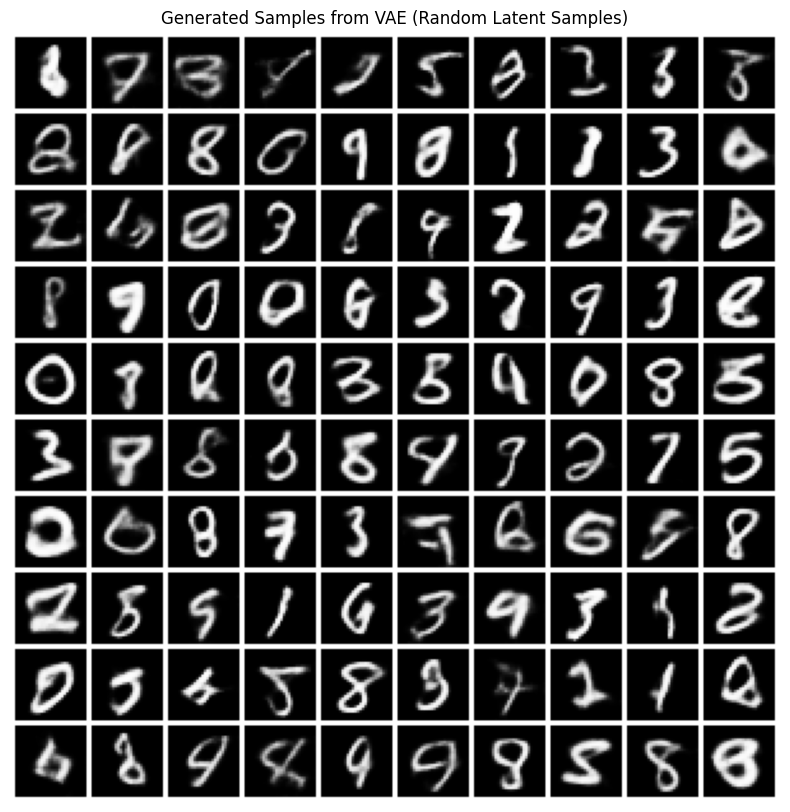

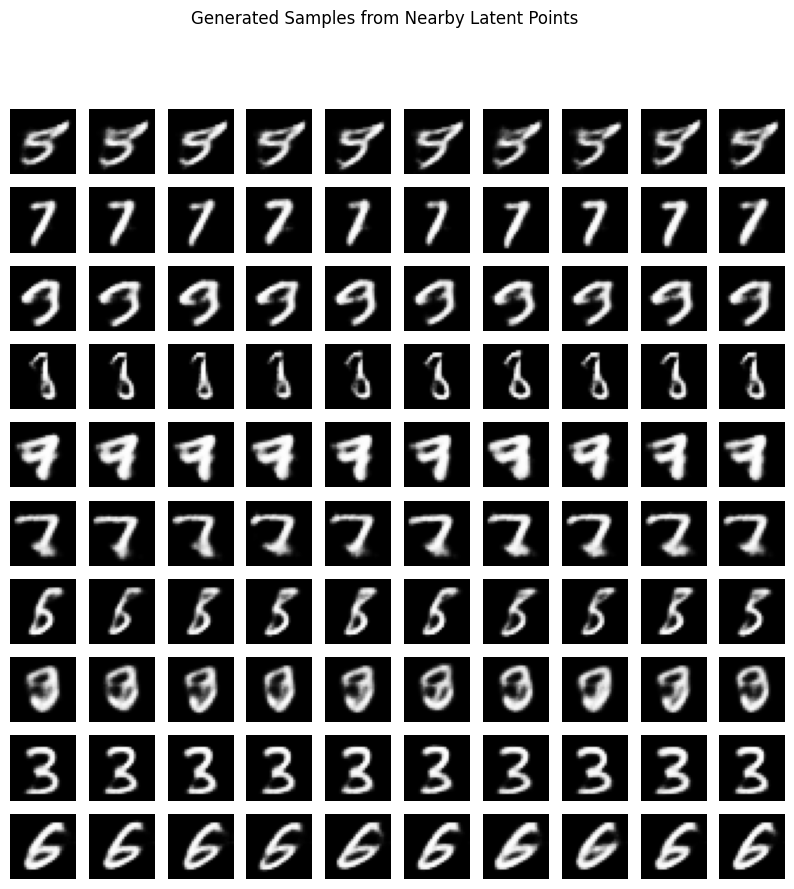

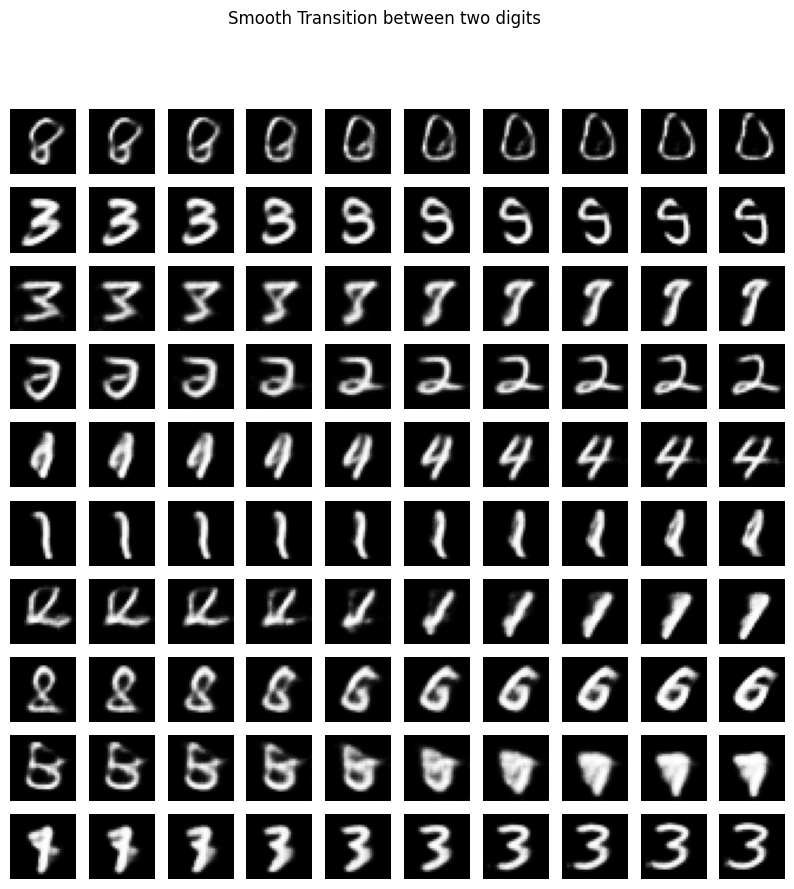

In [23]:
### (c) Continuity of the latent space ###
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
n = 10
z_samples = torch.normal(0,1,(n * n, latent_dim)).to(device)
generated = vae_model.decoder(z_samples).cpu()

# grid of random generated samples
grid = make_grid(generated, nrow=n, normalize=True, pad_value=1)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Generated Samples from VAE (Random Latent Samples)")
plt.axis('off')
plt.show()

# grid of Nearby samples
fig, axes = plt.subplots(n, n, figsize=(10, 10))
for i in range(n):
    z_center = torch.normal(0, 1, (1, latent_dim))
    nearby_z = z_center + torch.randn(n, latent_dim) * 0.2
    nearby_samples = vae_model.decoder(nearby_z.to(device)).cpu()
    for j in range(n):
        axes[i, j].imshow(nearby_samples[j][0].detach(), cmap='gray')
        axes[i, j].axis('off')
fig.suptitle("Generated Samples from Nearby Latent Points")
plt.show()

## Smooth transition between two digits
fig, axes = plt.subplots(n, n, figsize=(10,10))
for i in range(n):
    z1 = torch.normal(0, 1, (1, latent_dim))
    z2 = torch.normal(0, 1, (1, latent_dim))
    alpha = torch.linspace(0, 1, n)
    z_transition = z1 * alpha[:, None] + z2 * (1 - alpha[:, None])
    transition_samples = vae_model.decoder(z_transition.to(device)).cpu()
    for j in range(n):
        axes[i,j].imshow(transition_samples[j][0].detach(), cmap='gray')
        axes[i,j].axis('off')
fig.suptitle("Smooth Transition between two digits")
plt.show()

In [11]:
torch.save(vae_model.state_dict(), 'vae_model.pth')

In [42]:
images = inference(vae_model, ddpm1, t1= 0, t2 =5, num_samples = 5)

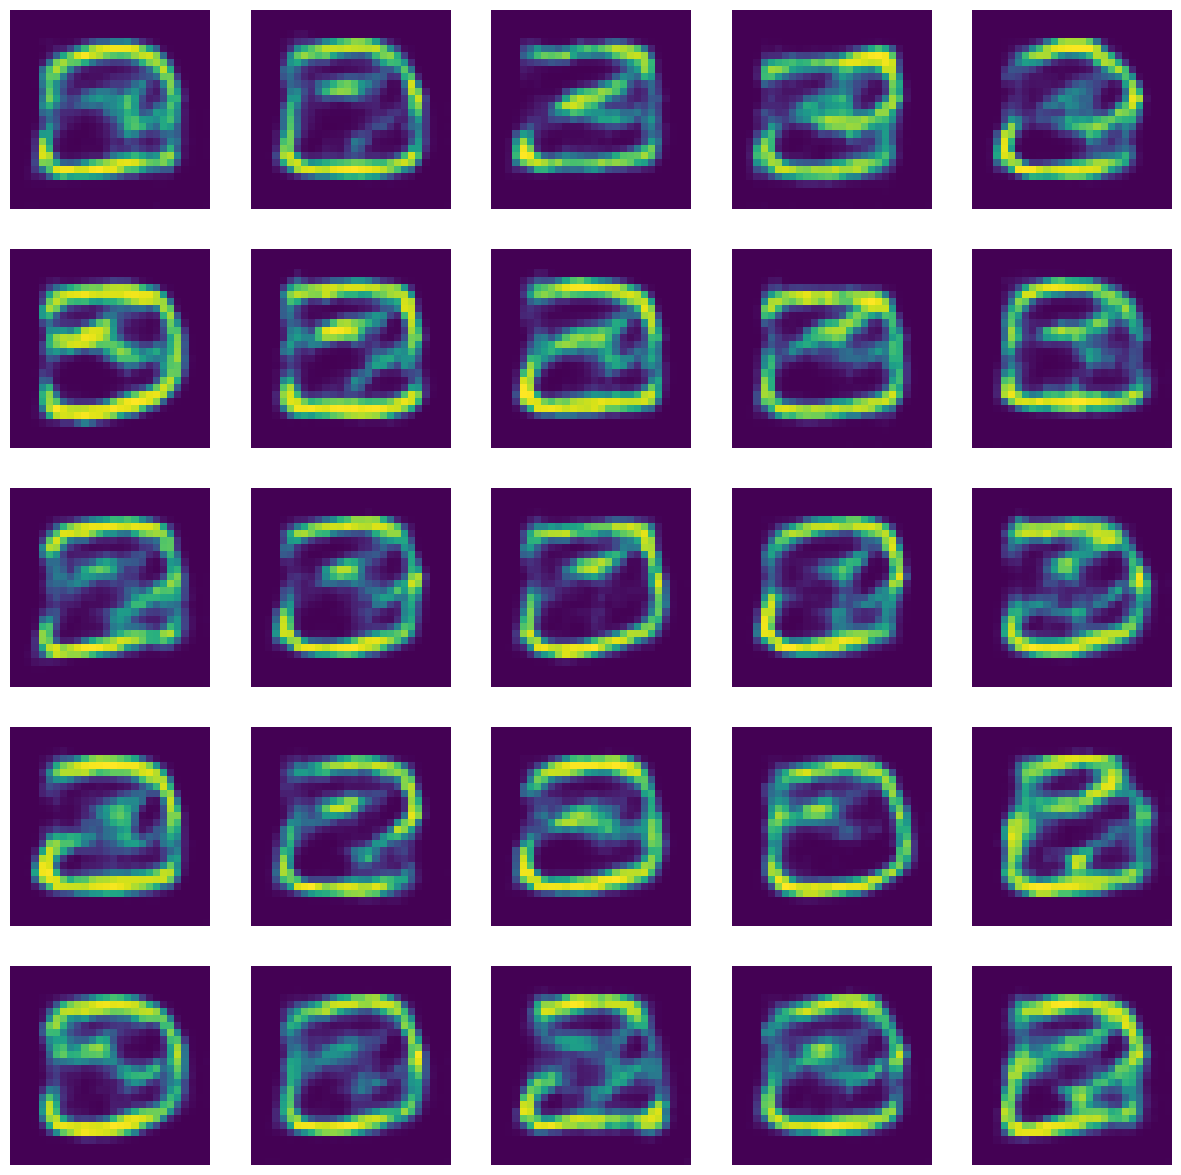

In [43]:
images = images.detach().cpu()
normalize = transforms.Normalize(0,1)
images = normalize(images)
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
  for j in range(5):
    axs[i,j].imshow(images[i*5 + j].permute(1,2,0))
    axs[i,j].axis('off')